In [1]:
!pip install textsearch
import nltk
nltk.download('punkt')

  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\Cuppi\anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Cuppi\\AppData\\Local\\Temp\\pip-install-2mnsx1_q\\pyahocorasick\\setup.py'"'"'; __file__='"'"'C:\\Users\\Cuppi\\AppData\\Local\\Temp\\pip-install-2mnsx1_q\\pyahocorasick\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\Cuppi\AppData\Local\Temp\pip-wheel-jy4_f0e_'
       cwd: C:\Users\Cuppi\AppData\Local\Temp\pip-install-2mnsx1_q\pyahocorasick\
  Complete output (5 lines):
  running bdist_wheel
  running build
  running build_ext
  building 'ahocorasick' extension
  error: Microsoft Visual C++ 14.0 is required. Get it with "Build Tools for Visual Studio": https://visualstudio.microsoft.com/downloads/
  ----------------------------------------
  ERROR: Failed building wh

  Using cached textsearch-0.0.21-py2.py3-none-any.whl (7.5 kB)
  Using cached pyahocorasick-1.4.2.tar.gz (321 kB)
  Running setup.py clean for pyahocorasick
Failed to build pyahocorasick
    Running setup.py install for pyahocorasick: started
    Running setup.py install for pyahocorasick: finished with status 'error'


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Cuppi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

In [3]:
dataset = pd.read_csv('C:/Users/Cuppi/Documents/Unterlagen_CAS_ML/04_Big_Data-20210221/Projekt/data.tsv', sep='\t', header = 0)
dataset.head()
dataset.count()

ID           17898
language     17898
score        17898
tweet_txt    17898
dtype: int64

In [4]:
# build train and test datasets
reviews = dataset['tweet_txt'].values
sentiments = dataset['score'].values

train_reviews = reviews[:12000]
train_sentiments = sentiments[:12000]

test_reviews = reviews[12000:]
test_sentiments = sentiments[12000:]

In [5]:
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def pre_process_corpus(docs):
    norm_docs = []
    for doc in docs:
        doc = doc.translate(doc.maketrans("\n\t\r", "   "))
        doc = doc.lower()
        doc = remove_accented_chars(doc)
        # lower case and remove special characters\whitespaces
        doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, flags=re.I|re.A)
        doc = re.sub(' +', ' ', doc) # the    dog  => the dog
        doc = doc.strip() 
        norm_docs.append(doc)
    return norm_docs

In [6]:
norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

In [7]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [8]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('httptcocvppsokibn', 29874), ('<PAD>', 0), 1)

In [9]:
train_sequences = t.texts_to_sequences(norm_train_reviews)
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [10]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=29875
Number of Documents=12000


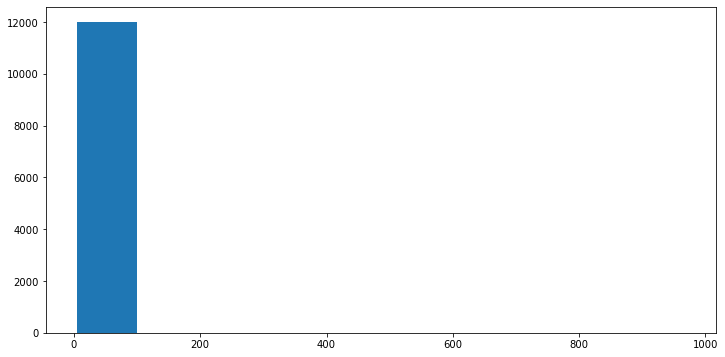

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]

fig, ax = plt.subplots(1,1, figsize=(12, 6))
h1 = ax.hist(train_lens)

In [12]:
MAX_SEQUENCE_LENGTH = 200

In [13]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((12000, 200), (5898, 200))

In [14]:
le = LabelEncoder()
num_classes=3 # positive -> 2, neutral -> 1, negative -> 0

In [15]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

Prepare the Model

In [16]:
VOCAB_SIZE = len(t.word_index)

In [17]:
EMBED_SIZE = 300
EPOCHS=10
BATCH_SIZE=128

In [18]:
# create the model
model = Sequential()

model.add(Embedding(VOCAB_SIZE, 
                    EMBED_SIZE, 
                    input_length=MAX_SEQUENCE_LENGTH))

model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 300)          8962500   
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 128)          153728    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 64)           32832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 32)            8224      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 25, 32)            0

Model Training

In [ ]:
# callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

# Fit the model
model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE,
          callbacks=[es], 
          verbose=1)

Epoch 1/10


Model Evaluation

In [1]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

NameError: name 'model' is not defined

In [2]:
predictions = ['positive' if item == 1 else 'negative' for item in predictions]
predictions[:10]

NameError: name 'predictions' is not defined

In [3]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

NameError: name 'test_sentiments' is not defined